# Overview
Creating output PDF with all non-trivial analyzed trees plotted with the corresponding monophyletic groups marked.

# Load libraries

In [1]:
import ete3, pandas as pd, glob, toytree, tqdm
import toyplot.pdf

# Define auxiliary functions

In [2]:
class Annotator(object):
    """
    Add annotations as a new mark on top of an existing toytree mark.
    """
    def __init__(self, tree, axes, mark):
        self.tree = tree
        self.axes = axes
        self.mark = mark


    def draw_clade_box(
        self, 
        names=None, 
        regex=None, 
        wildcard=None, 
        yspace=None, 
        xspace=None, 
        **kwargs):
        """
        Draw a rectangle around a clade on a toytree.
        Parameters:
        -----------
        names, regex, wildcard:
            Choose one of these three methods to select one or more tipnames. 
            The clade composing all descendants of their common ancestor will 
            be highlighted.
        yspace (float or None):
            The extent to which boxes extend above and below the root and tip
            nodes. If None then this is automatically generated.
        xspace (float or None):
            The extent to which the clade box extends to the sides 
            (out of the clade towards other tips.) If None default uses 0.5.
        kwargs:
            Additional styling options are supported: color, opacity, etc.
        Returns:
        ------------
        Toyplot.mark.Range
        """

        # get the common ancestor
        nidx = self.tree.get_mrca_idx_from_tip_labels(
            names=names, regex=regex, wildcard=wildcard)

        # get tips descended from mrca
        tips = self.tree.idx_dict[nidx].get_leaves()
        tidxs = [i.idx for i in tips]

        # extent to which box bounds extend outside of the exact clade size.
        if not yspace:
            yspace = 0.01#self.tree.treenode.height / 15.
        if not xspace:
            xspace = 0.01#0.45

        # left and right positions
        if self.mark.layout == 'r':
            xmin = self.mark.ntable[nidx, 0] - yspace
            xmax = max(self.mark.ntable[tidxs, 0]) + yspace
            ymin = min(self.mark.ntable[tidxs, 1]) - xspace
            ymax = max(self.mark.ntable[tidxs, 1]) + xspace   
  
        if self.mark.layout == 'l':
            xmin = self.mark.ntable[nidx, 0] + yspace
            xmax = max(self.mark.ntable[tidxs, 0]) - yspace
            ymin = max(self.mark.ntable[tidxs, 1]) + xspace
            ymax = min(self.mark.ntable[tidxs, 1]) - xspace

        elif self.mark.layout == 'd':
            ymax = self.mark.ntable[nidx, 1] + yspace
            ymin = min(self.mark.ntable[tidxs, 1]) - yspace
            xmin = min(self.mark.ntable[tidxs, 0]) - xspace
            xmax = max(self.mark.ntable[tidxs, 0]) + xspace               

        elif self.mark.layout == 'u':
            ymin = self.mark.ntable[nidx, 1] - yspace
            ymax = min(self.mark.ntable[tidxs, 1]) + yspace
            xmin = min(self.mark.ntable[tidxs, 0]) - xspace
            xmax = max(self.mark.ntable[tidxs, 0]) + xspace               

        # draw the rectangle
        newmark = self.axes.rectangle(xmin, xmax, ymin, ymax, **kwargs)

        # put tree at the top of the scenegraph
        self.axes._scenegraph.remove_edge(self.axes, 'render', self.mark)
        self.axes._scenegraph.add_edge(self.axes, 'render', self.mark)

        return newmark


In [3]:
# embedding PDF
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)


# Plot

In [4]:
# load the relevant data from table
monophyletic_groups_table = pd.read_csv('../results/misc/inparalog_code_correspondance.tsv', sep = '\t')

In [5]:
monophyletic_groups_table.head()

,monophyletic_group_code,Genes,Homolog group,Multiple sequence alignment,Phylogenetic tree,Species
0,F33_CLN_G1,"csin104442, csin111013",10238_cln.10238.faa,10238_cln.10238.faa.msa,10238_cln.10238.faa.msa.tree.,C. sinensis
1,F62_CLN_G1,"csin111800, csin107628, csin112559, csin104248...",1062_cln.1062.faa,1062_cln.1062.faa.msa,1062_cln.1062.faa.msa.tree.,C. sinensis
2,F82_CLN_G1,"csin109340, csin112280, csin108000, csin107009...",1099_cln.1099.faa,1099_cln.1099.faa.msa,1099_cln.1099.faa.msa.tree.,C. sinensis
3,F124_CLN_G1,"csin112045, csin108631",11357_cln.11357.faa,11357_cln.11357.faa.msa,11357_cln.11357.faa.msa.tree.,C. sinensis
4,F199_CLN_G1,"csin103192, csin103191",11845_cln.11845.faa,11845_cln.11845.faa.msa,11845_cln.11845.faa.msa.tree.,C. sinensis


In [6]:
# load code2genes table and create dict

In [7]:
tabla_codigo = pd.read_csv('../results/misc/internalcode2wbpsds.tsv', sep = '\t')

In [8]:
internal2wbps = {row['code']: row['wbps_id'] for index,row in tqdm.tqdm(pd.read_csv('../results/misc/internalcode2wbpsds.tsv', sep = '\t').iterrows())}

894432it [00:28, 31131.30it/s]


In [9]:
# getting the inverted dictionary
wbps2internal = {item:key for key,item in internal2wbps.items()}

# Plotting

In [18]:
for phylogenetic_tree,monophyletic_groups_detected_table in tqdm.tqdm(monophyletic_groups_table.groupby('Phylogenetic tree')):
    try:
        tree_monophyly_detected_file = '../results/phylogenetic_trees/' + phylogenetic_tree.replace('.tree.', '.tree')
        # get tree
        tree_monophyly_detected = toytree.tree(tree_monophyly_detected_file)
        # get node supports
        sups = tree_monophyly_detected.get_node_values("support", show_root=True, show_tips=True)
        # rooting by monophyletic groups; last (arbitrary) group is going to act as outgroup for visualization purposes
        if len([name for name, group in monophyletic_groups_detected_table.groupby('monophyletic_group_code')]) > 1:
            for name, group in monophyletic_groups_detected_table.groupby('monophyletic_group_code'):
                # get Choi seqs
                target_seqs = []
                for seq in group['Genes'].to_list()[0].split(', '):
                    target_seqs.append(wbps2internal[seq])
                tree_monophyly_detected = tree_monophyly_detected.root(names = target_seqs)
        # plot
        canvas, axes, mark = tree_monophyly_detected.draw(tip_labels_align=False,
                                        tip_labels = [internal2wbps[leaf]+ ' (' + leaf.upper() + ')' for leaf in tree_monophyly_detected.get_tip_labels()],
                                        height = 1200, width = 1200, scalebar=True, node_labels="support",
            tip_labels_style={"font-size": "11px"},
            node_labels_style={"font-size": "10px"},
            node_markers="r1.75x1.0",
            node_sizes=12,
            node_style={
                "fill": "lightblue",
                "stroke": "black",
                "stroke-width": 0.75,
            }
        
        )         
        # get annotator tool
        anno = Annotator(tree_monophyly_detected, axes, mark)
        # annotate groups
        for name, group in monophyletic_groups_detected_table.groupby('monophyletic_group_code'):
                    # get Choi seqs
                    target_seqs = []
                    for seq in group['Genes'].to_list()[0].split(', '):
                        target_seqs.append(wbps2internal[seq])
                    # create mixed list with both
                    monophyletic_seqs = target_seqs
                    #for ...
                    #print(monophyletic_seqs)
                    # annotate clade 
                    anno.draw_clade_box(
                        names = monophyletic_seqs,
                        #xspace = None, yspace = 0.45,
                        style={
                            "fill": 'red',
                            "fill-opacity": 0.15,
                            "stroke-width": 2, 
                            "stroke": 'red',
                            "stroke-opacity": 0.3,
                        },
                    );
        # save pdf
        group_tag = list(set(monophyletic_groups_detected_table['monophyletic_group_code'].to_list()))[0].rpartition('_')[0]
        # add title
        canvas.text(text = 'Phylogenetic tree code: {0}'.format(group_tag), x = 100, y = 25, style = {'font-size' : "15px"})
        tree_pdf_output = '../results/phylogenetic_trees_plot/{0}.pdf'.format(group_tag) 
        toyplot.pdf.render(canvas, tree_pdf_output)
    except Exception as e:
        pass

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24926/24926 [13:16<00:00, 31.31it/s]


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t30d0659d7c844c208bed997d3df15fff"> 99 41 96 98 97 45 Smp_301600 (SCM.10434) Smp_045070 (SCM.1851) SROB_0000866501 (SCR.8663) SMTD_0000493301 (SCT.4934) SMRZ_0001859201 (SCW.18591) MS3_09410 (SCH.10049) Sjp_0064900 (SCJ.10513) TRE_0001205801 (TRC.12048) T265_13519 (OPV.11454) 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 1.0 1.1 1.2

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t7d7f40c1d6ac4e6bb96b58ce4de7a66d"> 97 Smp_319600 (SCM.11642) Smp_175200 (SCM.8426) MS3_07608 (SCH.8133) T265_14118 (OPV.14628) 0.00 0.09 0.18 0.27 0.36 0.46 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t14c8516b5b744df597f5ae3ca0b58a37"> 76 68 100 84 Smp_049230 (SCM.2043) Smp_048050 (SCM.1998) SROB_0000012301 (SCR.124) SMTD_0000189101 (SCT.1892) SCUD_0000372201 (SCC.3722) SMRZ_0002408301 (SCW.24082) Sjp_0021230 (SCJ.6719) 0.00 0.03 0.07 0.10 0.13 0.16 0.20 0.23 0.26 0.30 0.33 0.36

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t686f55a134dd4e97a154ba80397f8646"> 77 88 100 68 MS3_04933 (SCH.5278) SCUD_0000481301 (SCC.4813) SMTD_0000413101 (SCT.4132) SMRZ_0002587701 (SCW.25876) SROB_0002056201 (SCR.20560) Smp_328240 (SCM.12317) Smp_346160 (SCM.14242) 0.00 0.01 0.02 0.03 0.05 0.06 0.07 0.08 0.09 0.10 0.11 0.13

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9800d32fad3b4fa389965c9870727274"> 61 97 98 46 100 77 SMTD_0000427001 (SCT.4271) MS3_11114 (SCH.758) SMRZ_0001419101 (SCW.14190) SMRZ_0002302701 (SCW.23026) MS3_11152 (SCH.801) SCUD_0000543501 (SCC.5435) SROB_0000064801 (SCR.649) Smp_112450 (SCM.4066) Smp_077890 (SCM.3127) 0.0 0.1 0.2 0.3 0.4 0.6 0.7 0.8 0.9 1.0 1.1 1.2

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2d9122bd66cc448999078b2d9596e70a"> 71 99 100 MS3_10152 (SCH.10848) SCUD_0001329701 (SCC.13294) SMRZ_0002097801 (SCW.20977) Smp_303570 (SCM.10554) Smp_054320 (SCM.2236) Sjp_0070240 (SCJ.2394) 0.00 0.05 0.11 0.16 0.21 0.26 0.32 0.37 0.42 0.48 0.53 0.58

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t05ca68b8e4b44a6788dd5f723234dbd3"> 100 97 SCUD_0001597001 (SCC.15967) SMRZ_0001992301 (SCW.19922) Smp_184350 (SCM.8790) Smp_319340 (SCM.11619) Sjp_0010360 (SCJ.11309) 0.00 0.02 0.05 0.07 0.09 0.11 0.14 0.16 0.18 0.20 0.23 0.25

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td9e57963867a4ccc8c90a676f132875b"> 66 91 99 99 96 Smp_335360 (SCM.13090) Smp_328470 (SCM.12334) Smp_328450 (SCM.12332) MS3_09688 (SCH.10349) SCUD_0001723801 (SCC.17235) Sjp_0024630 (SCJ.2629) SROB_0000078301 (SCR.784) SMRZ_0001149601 (SCW.11495) 0.00 0.09 0.18 0.26 0.35 0.44 0.53 0.61 0.70 0.79 0.88 0.97

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t8bb7ad672c284209b7d8ff1ddc609c4a"> 84 80 71 69 100 94 100 Smp_332150 (SCM.12691) Smp_316790 (SCM.11403) Smp_335780 (SCM.13130) Smp_335930 (SCM.13147) Smp_303010 (SCM.10518) SCUD_0001773101 (SCC.17728) SMRZ_0001093501 (SCW.10934) SMRZ_0000530501 (SCW.5304) MS3_09774 (SCH.10445) Smp_314170 (SCM.11182) 0.00 0.03 0.05 0.08 0.11 0.14 0.16 0.19 0.22 0.25 0.27 0.30

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0072e685bbfe4dcb9c5ff9735e147ae3"> 48 100 91 SMRZ_0002176701 (SCW.21766) SCUD_0002164001 (SCC.21637) SMTD_0000163401 (SCT.1635) SROB_0001455701 (SCR.14555) Smp_173360 (SCM.8315) Smp_124890 (SCM.4386) 0.00 0.06 0.12 0.18 0.24 0.30 0.36 0.42 0.48 0.54 0.60 0.66

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t7007a20d74ea4c2ba3169d291fac4802"> 84 100 100 Smp_333000 (SCM.12802) Smp_099090 (SCM.3847) Smp_306350 (SCM.10744) SMRZ_0000465201 (SCW.4651) MS3_05060 (SCH.5430) Sjp_0036210 (SCJ.3462) 0.00 0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.30 0.33

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te51dc04a025a44f6a98e5f3d2476ef03"> 91 Smp_316020 (SCM.11328) Smp_312950 (SCM.11132) SROB_0002108801 (SCR.21086) MS3_08172 (SCH.8718) 0.00 0.02 0.04 0.06 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.24

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t147158b0d3b64974adaa42aecff24ef1"> 100 SMRZ_0001802801 (SCW.18027) MS3_09108 (SCH.9729) Smp_333830 (SCM.12906) Smp_327950 (SCM.12289) 0.00 0.08 0.17 0.25 0.33 0.41 0.50 0.58 0.66 0.74 0.83 0.91

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t240a3398fa81496f9f6c02db87b5aa4b"> 73 59 Smp_337730 (SCM.13348) Smp_311660 (SCM.11060) Smp_311670 (SCM.11063) Smp_307450 (SCM.10826) MS3_09690 (SCH.10348) 0.00 0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.23 0.26 0.29 0.32

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t79962eb134bd4185a13593928f8a9291"> 100 100 98 99 Smp_310050 (SCM.10983) Smp_310040 (SCM.10982) SROB_0000290201 (SCR.2902) Smp_138750 (SCM.5523) SMRZ_0000403601 (SCW.4037) MS3_09887 (SCH.10565) Sjp_0026160 (SCJ.7570) 0.00 0.09 0.17 0.26 0.35 0.43 0.52 0.61 0.69 0.78 0.87 0.95

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tddb58a1d18734939a1c83e24bdbfba5b"> 98 100 100 99 Smp_336380 (SCM.13201) Smp_142860 (SCM.5892) Smp_332230 (SCM.12699) Sjp_0044100 (SCJ.272) SMTD_0000836201 (SCT.8363) SMRZ_0001666101 (SCW.16660) Smp_137740 (SCM.5436) 0.00 0.05 0.10 0.16 0.21 0.26 0.31 0.36 0.42 0.47 0.52 0.57

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tfcfce622c9274da5a3dea2e5587bd9ad"> 98 Smp_309720 (SCM.10963) Smp_309710 (SCM.10960) SROB_0000001101 (SCR.12) Sjp_0027880 (SCJ.1355) 0.00 0.04 0.08 0.12 0.16 0.20 0.24 0.28 0.32 0.36 0.40 0.44

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2ab36a8e1ee0485b9d8256faef420352"> Smp_056460 (SCM.2332) Smp_330120 (SCM.12482) Smp_318820 (SCM.11568) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t819b8e4f942c42a8a4518bdb54576308"> Smp_085410 (SCM.3392) Smp_321120 (SCM.11762) Smp_327370 (SCM.12242) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td1ff251799874a3684211612351d9d67"> Smp_326790 (SCM.12192) Smp_122630 (SCM.4189) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t42ba4c3c12a54414989b21693ce5b89d"> 63 52 Smp_324250 (SCM.12020) Smp_345180 (SCM.14096) Smp_131490 (SCM.4970) Smp_131470 (SCM.4967) SMRZ_0002481601 (SCW.24815) 0.00 0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.25 0.28 0.31 0.34

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb9cdfca5488448e299c13a3be90b70a5"> Smp_329280 (SCM.12411) Smp_149750 (SCM.6506) Smp_329270 (SCM.12409) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta40078ac55904aef9b1b03d38a30bf9a"> Smp_152280 (SCM.6678) Smp_152290 (SCM.6679) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t54a13b95746a4728975b79a5245a6410"> Smp_330210 (SCM.12493) Smp_152590 (SCM.6708) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t36bc834da0cf4e71aad17c1b1615d919"> Smp_326580 (SCM.12170) Smp_302220 (SCM.10465) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb5120cae54214754a0cfcbe5f0300e57"> Smp_303690 (SCM.10573) Smp_302350 (SCM.10478) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdce92c3364a74cec8bad91ce2ce0f321"> Smp_303450 (SCM.10540) Smp_314670 (SCM.11211) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb71e15c68bd2459cbc9e46be47c4462c"> 81 Smp_306740 (SCM.10771) Smp_324080 (SCM.12003) Smp_306750 (SCM.10772) SMTD_0000041801 (SCT.419) 0.0 0.7 1.4 2.2 2.9 3.6 4.3 5.0 5.7 6.5 7.2 7.9

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te51d225c175d4751bacab2bff722918d"> Smp_307220 (SCM.10812) Smp_307240 (SCM.10814) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t3f776d7edf804de38f5506e381615212"> Smp_327920 (SCM.12287) Smp_310740 (SCM.11013) Smp_327910 (SCM.12284) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tfe3a6f2ab70e449982618c4c126fb984"> Smp_315060 (SCM.11224) Smp_337100 (SCM.13259) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t328405c7ccaf4daa8b32c72cb09c5598"> 0 Smp_317430 (SCM.11444) Smp_315230 (SCM.11232) Smp_331230 (SCM.12598) Smp_331240 (SCM.12600) 0.0 0.2 0.4 0.5 0.7 0.9 1.1 1.3 1.5 1.6 1.8 2.0

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t01a6f6906b074e1fb0d805437091c89d"> Smp_316220 (SCM.11347) Smp_337070 (SCM.13253) Smp_316250 (SCM.11350) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tebd4add5e36d4bc5ac37980f063bf4d0"> Smp_341290 (SCM.13554) Smp_316490 (SCM.11372) Smp_331120 (SCM.12582) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf7e84bd5064f4d9d9c3dd2e3aee97b47"> Smp_317120 (SCM.11418) Smp_329690 (SCM.12441) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tce54a2b274014fc4b535b67065265082"> Smp_317970 (SCM.11493) Smp_317980 (SCM.11496) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t4c39e0e9f0b64a5fb0fc14515bb4ab62"> Smp_323320 (SCM.11939) Smp_323270 (SCM.11932) Smp_319290 (SCM.11610) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6520950c7c8646208591586b0ccb2fa9"> Smp_319690 (SCM.11651) Smp_319700 (SCM.11653) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc18ee9c5e34b47939a537c3c2e6dc484"> Smp_319770 (SCM.11657) Smp_344070 (SCM.13928) Smp_319780 (SCM.11660) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6593d5dafeb3462d9a740d0f15d5876c"> Smp_335400 (SCM.13093) Smp_320880 (SCM.11743) Smp_329050 (SCM.12391) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdbb98d1ae90f45299fe744b0347040f1"> Smp_321200 (SCM.11768) Smp_329810 (SCM.12452) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t1de4f5426ac6468699f6031098c0cd4b"> Smp_321790 (SCM.11821) Smp_347250 (SCM.14404) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9ade1119c78d437aa6a12db37ea80c70"> Smp_324560 (SCM.12042) Smp_324300 (SCM.12025) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t3c84f7a1ed48498e96cc25279727a780"> Smp_330130 (SCM.12483) Smp_328810 (SCM.12370) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t16d88417dd4a436190c2876f341e0401"> Smp_344470 (SCM.13984) Smp_328820 (SCM.12373) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tce237693c9034878baffb45029d055a9"> 0 Smp_330070 (SCM.12476) Smp_330060 (SCM.12475) Smp_330080 (SCM.12477) Smp_330100 (SCM.12479) 0.0 0.2 0.4 0.5 0.7 0.9 1.1 1.3 1.5 1.6 1.8 2.0

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t64f5371e0c004ffba56173a2f61121ab"> Smp_330900 (SCM.12560) Smp_344300 (SCM.13957) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2372ab16311e466f9c891a53072d2b0b"> Smp_331130 (SCM.12585) Smp_331140 (SCM.12588) 0.00 0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tfd27542cb6cb41df8eb330dfb282deb8"> 100 T265_09934 (OPV.2783) csin107605 (CLN.6217) Smp_322080 (SCM.11841) Smp_093780 (SCM.3652) 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te107cd00e78449b79588b26865728e2c"> 99 67 38 100 60 100 99 79 94 100 97 94 78 MS3_07411 (SCH.7915) SCUD_0000986901 (SCC.9869) Smp_317150 (SCM.11423) Smp_314200 (SCM.11184) Sjp_0057590 (SCJ.11855) maker-scaffold10x_1178_pilon-augustus-gene-0.59 (FSC.950) HmN_000530500 (HYM.4963) HDID_0000886101 (HYD.8859) HNAJ_0001265501 (HYN.12633) MCOS_0000822401 (MSC.8225) TSAs00086g08173 (TAS.8173) TASs00096g07271 (TAA.7271) TsM_000663800 (TAE.4844) EmuJ_001133900 (ECM.9604) EcG7_04142 (ECD.4139) EgrG_001133900 (ECG.2226) 0.0 0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3.0 3.3

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf43e490b20034f9abcf853b8926c5011"> 100 100 100 99 100 100 82 100 Smp_125560 (SCM.4432) MS3_06877 (SCH.7352) Smp_311350 (SCM.11037) Smp_266800 (SCM.10299) SMTD_0000678801 (SCT.6789) SMRZ_0000099301 (SCW.994) MS3_09914 (SCH.10596) Smp_209040 (SCM.9273) Smp_175090 (SCM.8422) maker-scaffold10x_158_pilon-snap-gene-0.43 (FSC.2250) T265_02085 (OPV.8127) 0.00 0.09 0.18 0.28 0.37 0.46 0.55 0.64 0.74 0.83 0.92 1.01

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t610ef9d9fe0f4152a9ede9a4a03720c7"> 0 46 100 100 100 91 100 Smp_323510 (SCM.11959) Smp_323490 (SCM.11956) Smp_178360 (SCM.8578) Smp_323500 (SCM.11957) SROB_0000025501 (SCR.256) MS3_04720 (SCH.5062) maker-scaffold10x_1593_pilon-augustus-gene-0.12 (FSC.2265) ECPE_0001322601 (ECP.13187) csin100641 (CLN.13081) Sjp_0098950 (SCJ.6304) 0.0 0.1 0.2 0.3 0.4 0.6 0.7 0.8 0.9 1.0 1.1 1.2

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdd5e2dc6be584c689975d06f37e12e40"> 56 91 59 100 92 95 93 78 98 96 98 98 75 100 72 91 98 100 63 90 61 100 86 50 98 SMRZ_0000466801 (SCW.4667) SCUD_0000861101 (SCC.8611) SMTD_0000164401 (SCT.1645) MS3_04221 (SCH.4535) Smp_309930 (SCM.10973) Smp_064320 (SCM.2624) SROB_0001038401 (SCR.10382) Sjp_0036030 (SCJ.7853) maker-scaffold10x_2067_pilon-augustus-gene-0.8 (FSC.3140) ECPE_0001106501 (ECP.11031) T265_07694 (OPV.15941) csin109959 (CLN.4787) PXEA_0001032601 (PPX.10278) TSAs00014g03042 (TAS.3042) TASs00011g02597 (TAA.2597) TsM_000661400 (TAE.5106) EcG7_03535 (ECD.3532) EmuJ_000872400 (ECM.7194) EgrG_000872400 (ECG.5364) TTAC_0000796501 (HTF.7950) HNAJ_0000888301 (HYN.8879) HmN_000779400 (HYM.7332) HDID_0000289101 (HYD.2889) MCOS_0000864401 (MSC.8645) SPER_0003790501 (SPE.37620) DILT_0000590101 (DPY.5887) SSLN_0000983201 (SCS.9472) BOX15_Mlig026922g1 (MSL.4308) 0.0 0.2 0.3 0.5 0.6 0.8 1.0 1.1 1.3 1.5 1.6 1.8

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc9b9ca7068024277b6022c99193da56b"> 83 96 79 55 60 52 98 98 89 67 96 100 SCUD_0001254801 (SCC.12545) SMTD_0000851701 (SCT.8518) SMRZ_0001567201 (SCW.15671) Smp_331990 (SCM.12680) Smp_327500 (SCM.12254) Smp_303430 (SCM.10539) TRE_0001856601 (TRC.18552) Sjp_0114790 (SCJ.237) maker-scaffold10x_209_pilon-snap-gene-0.31 (FSC.3203) ECPE_0001667701 (ECP.16634) csin111258 (CLN.8078) SPER_0001784801 (SPE.17727) SSLN_0001515901 (SCS.14606) DILT_0001070701 (DPY.10679) MCOS_0000452901 (MSC.4530) 0.0 0.1 0.2 0.4 0.5 0.6 0.7 0.8 1.0 1.1 1.2 1.3

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t475c67fc50de4192862910219fec3aa5"> 71 100 100 99 100 100 100 54 SCUD_0001394401 (SCC.13941) MS3_04561 (SCH.4890) SMRZ_0001567001 (SCW.15669) Smp_327530 (SCM.12258) Smp_122820 (SCM.4201) Sjp_0022380 (SCJ.480) maker-scaffold10x_209_pilon-snap-gene-0.49 (FSC.3218) ECPE_0000887201 (ECP.8844) T265_01217 (OPV.6081) csin111257 (CLN.2074) SSLN_0000989101 (SCS.9529) 0.00 0.08 0.17 0.25 0.33 0.41 0.50 0.58 0.66 0.74 0.83 0.91

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6a94194b11b74a5d925ecd4a7fe457d9"> 59 91 66 89 100 100 100 Smp_321400 (SCM.11790) Smp_245970 (SCM.10030) SROB_0000270001 (SCR.2700) SMRZ_0000294301 (SCW.2944) MS3_02910 (SCH.3140) Sjp_0066960 (SCJ.2358) maker-scaffold10x_2113_pilon-snap-gene-0.14 (FSC.3245) ECPE_0000876301 (ECP.8737) T265_13068 (OPV.8956) csin109955 (CLN.8834) 0.0 0.2 0.3 0.5 0.6 0.8 0.9 1.1 1.2 1.4 1.5 1.7

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t8dc8d8a477fd436e9b0c85d49f773c86"> 43 72 91 45 74 100 Smp_139580 (SCM.5595) Smp_032120 (SCM.1313) SROB_0000104101 (SCR.1042) SMTD_0001082701 (SCT.10828) MS3_05428 (SCH.5815) SMRZ_0000944901 (SCW.9448) T265_02982 (OPV.9369) maker-scaffold10x_254_pilon-augustus-gene-0.17 (FSC.3943) Sjp_0027520 (SCJ.3350) 0.0 0.1 0.2 0.4 0.5 0.6 0.7 0.8 1.0 1.1 1.2 1.3

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t3f665f3d82364cc1919cb8b9953be5c8"> 100 100 69 97 T265_01345 (OPV.7138) csin103006 (CLN.2337) maker-scaffold10x_2758_pilon-snap-gene-0.2 (FSC.4173) SMRZ_0001768401 (SCW.17683) MS3_02920 (SCH.3144) Smp_321430 (SCM.11792) Smp_212140 (SCM.9404) 0.0 0.1 0.3 0.4 0.6 0.7 0.9 1.0 1.2 1.3 1.5 1.6

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t31d6e25409ce4335b4ae1e6e4063e111"> 100 83 maker-scaffold10x_476_pilon-snap-gene-0.116 (FSC.5826) csin106942 (CLN.7354) Smp_307590 (SCM.10841) Smp_134530 (SCM.5191) MS3_01980 (SCH.2148) 0.0 0.2 0.3 0.5 0.6 0.8 1.0 1.1 1.3 1.5 1.6 1.8

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t1db5b215d617423d803fb70ae658c1d6"> 86 92 100 75 87 100 98 50 Smp_336700 (SCM.13217) Smp_328600 (SCM.12349) Sjp_0059850 (SCJ.7373) T265_11926 (OPV.5666) maker-scaffold10x_503_pilon-snap-gene-0.84 (FSC.6144) EmuJ_000394700 (ECM.2988) EgrG_000394700 (ECG.4951) EcG7_08977 (ECD.8942) TsM_000013300 (TAE.11855) HDID_0000029101 (HYD.292) HNAJ_0001148501 (HYN.11475) 0.0 0.2 0.3 0.5 0.7 0.9 1.0 1.2 1.4 1.5 1.7 1.9

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0dceb7f2a8554f0ca3446c8bdacb4c09"> 100 44 99 96 85 69 96 99 100 98 100 TSAs00004g01278 (TAS.1278) TASs00012g02754 (TAA.2754) TsM_000986600 (TAE.5830) EgrG_000699900 (ECG.5216) EcG7_01907 (ECD.1906) EmuJ_000699900 (ECM.5602) TTAC_0000622501 (HTF.6210) MCOS_0000149801 (MSC.1499) Smp_303640 (SCM.10566) Smp_010620 (SCM.471) MS3_00610 (SCH.6732) Sjp_0028430 (SCJ.9781) maker-scaffold10x_65_pilon-snap-gene-0.12 (FSC.7233) SSLN_0000982401 (SCS.9464) 0.00 0.09 0.18 0.27 0.36 0.46 0.55 0.64 0.73 0.82 0.91 1.00

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t85531c71a85049fc930cb72b3e62dd43"> 100 99 100 90 T265_12461 (OPV.7359) csin111442 (CLN.9246) maker-scaffold10x_721_pilon-augustus-gene-0.89 (FSC.7502) Smp_316750 (SCM.11396) Smp_196150 (SCM.8944) MS3_10464 (SCH.53) Sjp_0019390 (SCJ.10901) 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.9 1.0 1.1 1.2

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t07d80a2b478b45f291182a7d3a2c0106"> 92 83 100 51 67 84 92 56 100 97 99 93 100 89 EmuJ_000701200 (ECM.5613) EgrG_000701200 (ECG.7309) EcG7_04596 (ECD.4591) TSAs00004g01270 (TAS.1270) TASs00012g02745 (TAA.2745) TsM_000387100 (TAE.2175) TTAC_0000623201 (HTF.6217) MCOS_0000896001 (MSC.8961) HNAJ_0000144001 (HYN.1439) HmN_000769500 (HYM.7235) HDID_0000311901 (HYD.3117) SPER_0001335501 (SPE.13264) DILT_0001339101 (DPY.13354) maker-scaffold10x_7_pilon-augustus-gene-1.28 (FSC.7986) Smp_332220 (SCM.12697) Smp_157780 (SCM.7128) MS3_09137 (SCH.9760) 0.0 0.2 0.4 0.7 0.9 1.1 1.3 1.5 1.8 2.0 2.2 2.4

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t542d28d0862c4a10aabe008fc4556663"> 89 91 100 90 100 Smp_311740 (SCM.11065) Smp_137660 (SCM.5430) SROB_0000855901 (SCR.8557) MS3_01697 (SCH.1861) T265_11145 (OPV.4525) csin102312 (CLN.4944) maker-scaffold10x_80_pilon-snap-gene-0.177 (FSC.8093) Sjp_0006530 (SCJ.9105) 0.0 0.2 0.4 0.5 0.7 0.9 1.1 1.3 1.5 1.6 1.8 2.0

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t7b6f60f8c2134da7866163ef7c82681c"> 98 86 86 58 73 96 93 96 83 100 80 100 100 TSAs00043g05908 (TAS.5908) TASs00061g06041 (TAA.6041) TsM_000665900 (TAE.2082) EmuJ_000086900 (ECM.534) EcG7_05053 (ECD.5045) TTAC_0000648901 (HTF.6474) HNAJ_0001092001 (HYN.10914) HDID_0000067701 (HYD.678) HmN_000594000 (HYM.5570) SPER_0001942901 (SPE.19294) SSLN_0001724001 (SCS.16605) Smp_300390 (SCM.10376) Smp_300380 (SCM.10373) MS3_00908 (SCH.9587) Sjp_0073310 (SCJ.8638) snap_masked-scaffold10x_730_pilon-processed-gene-0.121 (FSC.9639) 0.0 0.2 0.4 0.6 0.8 1.0 1.2 1.5 1.7 1.9 2.1 2.3

In [20]:
tree_pdf_output

'../results/phylogenetic_trees_plot/F24926_GYS.pdf'

In [21]:
import os

In [22]:
# concatenating PDF
from PyPDF2 import PdfMerger

# define pdfs for merge
if not os.path.exists('../results/phylogenetic_trees_plot/trees_with_monophyletic_groups.pdf'):
    pdfs = glob.glob('../results/phylogenetic_trees_plot/*.pdf')
    merger = PdfMerger()
    for pdf in pdfs:
        merger.append(pdf)
    merger.write('../results/phylogenetic_trees_plot/trees_with_monophyletic_groups.pdf')
    merger.close()

OSError: [Errno 24] Too many open files: '../results/phylogenetic_trees_plot/F8605_MSL.pdf'

In [23]:
%system cp ../results/phylogenetic_trees_plot/F24926_GYS.pdf .

Exception in thread Exception in threading.excepthook:
Exception ignored in thread started by: <bound method Thread._bootstrap of <HistorySavingThread(IPythonHistorySavingThread, started 139984124245760)>>
Traceback (most recent call last):
  File "/home/mauricio/mauricio_PROGRAMAS/anaconda3/envs/py39/lib/python3.10/threading.py", line 973, in _bootstrap
  File "/home/mauricio/mauricio_PROGRAMAS/anaconda3/envs/py39/lib/python3.10/threading.py", line 1018, in _bootstrap_inner
  File "/home/mauricio/mauricio_PROGRAMAS/anaconda3/envs/py39/lib/python3.10/threading.py", line 1336, in invoke_excepthook
  File "/home/mauricio/mauricio_PROGRAMAS/anaconda3/envs/py39/lib/python3.10/site-packages/ipykernel/iostream.py", line 475, in flush
  File "/home/mauricio/mauricio_PROGRAMAS/anaconda3/envs/py39/lib/python3.10/site-packages/ipykernel/iostream.py", line 210, in schedule
  File "/home/mauricio/mauricio_PROGRAMAS/anaconda3/envs/py39/lib/python3.10/site-packages/ipykernel/iostream.py", line 98, i

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.

OSError: [Errno 24] Too many open files

In [ ]:
import shutil

In [ ]:
shutil.move(src = '../results/phylogenetic_trees_plot/trees_with_monophyletic_groups.pdf', 
            dst = '../results/trees_with_monophyletic_groups.pdf')

In [ ]:
%system rm ../results/phylogenetic_trees_plot/*
%system mv ../results/trees_with_monophyletic_groups.pdf ../results/phylogenetic_trees_plot/

## Little example

In [10]:
# get one case and plot as example
tree_monophyly_detected_file = '../results/phylogenetic_trees/84681_Fsc.134.faa.msa.contree.tree'

In [11]:
# get tree
tree_monophyly_detected = toytree.tree(tree_monophyly_detected_file)

In [12]:
monophyletic_groups_table['Phylogenetic tree'][0]

'10238_cln.10238.faa.msa.tree.'

In [13]:
tree_monophyly_detected

In [14]:
sups = tree_monophyly_detected.get_node_values("support", show_root=True, show_tips=True)


In [17]:
canvas, axes, mark = tree_monophyly_detected.draw(tip_labels_align=False,
                                tip_labels = [internal2wbps[leaf]+ ' (' + leaf.upper() + ')' for leaf in tree_monophyly_detected.get_tip_labels()],
                                                  height = 1200, width = 1200, scalebar=True, node_labels="support",
    tip_labels_style={"font-size": "11px"},
    node_labels_style={"font-size": "10px"},
    node_markers="r1.75x1.0",
    node_sizes=12,
    node_style={
        "fill": "lightblue",
        "stroke": "black",
        "stroke-width": 0.75,
    }

)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="1200.0px" viewBox="0 0 1200.0 1200.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9a6671e20a3a43749ff5293a6f562c39"> 51 58 66 100 99 64 93 99 97 94 93 99 100 76 93 88 47 100 97 100 99 98 37 100 100 85 89 84 100 100 97 100 100 100 100 76 52 65 0 100 88 100 100 94 59 62 HmN_002089300 (HYM.10317) HmN_000069600 (HYM.641) HmN_002272700 (HYM.12142) HNAJ_0001213301 (HYN.12122) HNAJ_0000691101 (HYN.6907) HDID_0000418401 (HYD.4182) EgrG_001193600 (ECG.91) EcG7_03368 (ECD.3365) EmuJ_001193600 (ECM.10114) TsM_000779800 (TAE.10701) TTAC_0000894201 (HTF.8927) MCOS_0000044301 (MSC.444) SSLN_0001209601 (SCS.11651) DILT_0000660401 (DPY.6584) SMTD_0001179801 (SCT.11799) SCUD_0000164501 (SCC.1646) SMRZ_0000135701 (SCW.1358) MS3_02915 (SCH.3146) Smp_034190 (SCM.1405) Smp_303610 (SCM.10561) Sjp_0055030 (SCJ.12500) ECPE_0000752301 (ECP.7507) csin110430 (CLN.7363) PXEA_0001897001 (PPX.18886) SMRZ_0000298501 (SCW.2986) MS3_09530 (SCH.10180) SROB_0000818401 (SCR.8182) Smp_166400 (SCM.7789) Sjp_0008030 (SCJ.3310) maker-scaffold10x_290_pilon-snap-gene-0.5 (FSC.4367) augustus_masked-scaffold10x_387_pilon-processed-gene-0.17 (FSC.134) T265_13782 (OPV.12843) csin108854 (CLN.7478) maker-scf7180006949430-augustus-gene-0.46 (GYS.3460) MS3_01780 (SCH.1937) PXEA_0000536101 (PPX.5335) mk4.015448.00 (STM.21032) mk4.046988.00 (STM.11969) mk4.038251.00 (STM.4590) mk4.003255.07 (STM.10153) mk4.006461.00 (STM.22546) mk4.007524.00 (STM.2978) BOX15_Mlig000514g2 (MSL.9437) BOX15_Mlig000514g1 (MSL.5721) BOX15_Mlig025077g2 (MSL.32191) BOX15_Mlig011711g5 (MSL.15810) BOX15_Mlig011711g2 (MSL.18777) genemark-scf7180006952656-processed-gene-0.5 (GYS.2530) mk4.000568.02 (STM.24111) 0.0 0.1 0.3 0.4 0.5 0.7 0.8 0.9 1.0 1.2 1.3 1.4

In [ ]:
# get the monohypletic groups for this
monophyletic_groups_detected_table = monophyletic_groups_table.query("`Phylogenetic tree` == '84681_Fsc.134.faa.msa.contree.tree.'")


In [ ]:
monophyletic_groups_detected_table

In [ ]:
# get annotator tool
anno = Annotator(tree_monophyly_detected, axes, mark)

In [ ]:
# get annotator tool
anno = Annotator(tree_monophyly_detected, axes, mark)
# annotate groups
for name, group in monophyletic_groups_detected_table.groupby('monophyletic_group_code'):
            # get Choi seqs
            target_seqs = []
            for seq in group['Genes'].to_list()[0].split(', '):
                target_seqs.append(wbps2internal[seq])
            # create mixed list with both
            monophyletic_seqs = target_seqs
            #for ...
            #print(monophyletic_seqs)
            # annotate clade 
            anno.draw_clade_box(
                names = monophyletic_seqs,
                #xspace = None, yspace = 0.45,
                style={
                    "fill": 'red',
                    "fill-opacity": 0.15,
                    "stroke-width": 2, 
                    "stroke": 'red',
                    "stroke-opacity": 0.3,
                },
            );

In [302]:
import os
os.mkdir('../results/phylogenetic_trees_plot')

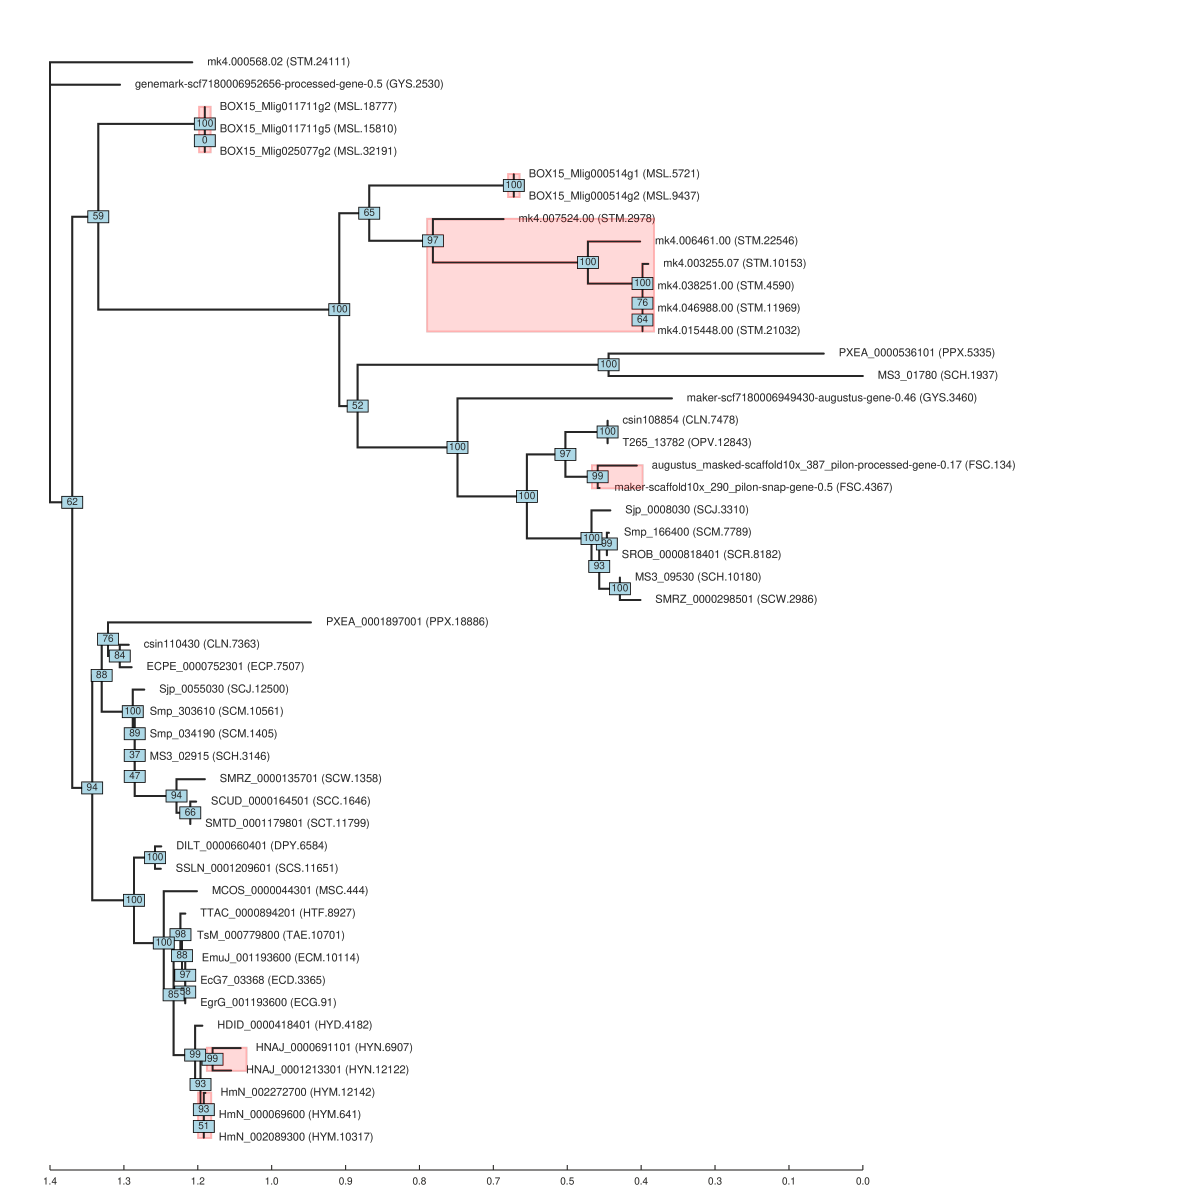

In [301]:
# save pdf
group_tag = tree_monophyly_detected_file.rpartition('/')[2]
tree_pdf_output = '../results/phylogenetic_trees_plot/{0}.pdf'.format(group_tag) 
toyplot.pdf.render(canvas, tree_pdf_output)